<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Spotify songs analysis with lyrics

Data contains almost **300.000** records, It was created by me, in the steps presented in **dataset-creator.jpynb**. Around **~32.000** rows have its own unique **Lyrics** scraped from **genius.com**. However every row contains features like:<br>

- **Song Name**
- **Release Date**
- **Album Popularity**
- **Artist Popularity**
- **Song Popularity**
- **Artist Genres**
- **Language of Lyrics**
- **Duration**
- **Whether it is a solo song or with someone**
- Other technical features f.ex. **Loudness**, **Danceability**, **Liveness**, ...


One of the main purposes of this analysis is to see how different technical features vary across different **genres**, **languages** and other factors.<br><br>
Next thing that would be nice is checking how the **dictionary of words changes with years** in songs across different genres, what are the **most common words** in genres across years, and maybe find some other interesting aspects.<br>

I would also like to **create an estimator**, that will be able distinguish the **genre** of the song or specify which genre is the closest to your writing style.<br>
<br>



In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy as sp
from db_management.db import SongsDB
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("inferno")
database = SongsDB()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's load the data



In [34]:
df_lyrics = database.get_data()
df_lyrics.head(2)

,song_title,song_release_date,featured,song_popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,duration_ms,artist_name,artist_genres,artist_popularity,artist_followers,album_name,album_release_date,album_total_tracks,album_popularity,lyrics
0,House of the rising sun (style the animals) - ...,2014,0,0,0.0011,0.350,0.595,0.849000,0.106,-8.902,...,269219.0,Italian Hitmakers,,21.0,1507.0,Basi musicale nello stilo dei vari artisti (in...,2014,15,0,None
1,It's All Over Now - Mono Version,1964-10-17,0,47,0.0235,0.603,0.689,0.000003,0.330,-10.729,...,206440.0,The Rolling Stones,"album rock,british invasion,classic rock,rock",79.0,14083807.0,12 X 5,1964-10-17,12,45,"Well, baby used to stay out all night long Sh..."


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Quick Data Insight

There is some missing data especially related with artists, need to check it out. However creating the dataset, I know that there is also quite of a **missing values in a form of empty strings**, this is also something I need to be aware of.


In [12]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296029 entries, 0 to 296028
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   song_title          296029 non-null  object 
 1   song_release_date   296029 non-null  object 
 2   featured            296029 non-null  int64  
 3   song_popularity     296029 non-null  int64  
 4   acousticness        295785 non-null  float64
 5   danceability        295785 non-null  float64
 6   energy              295785 non-null  float64
 7   instrumentalness    295785 non-null  float64
 8   liveness            295785 non-null  float64
 9   loudness            295785 non-null  float64
 10  speechiness         295785 non-null  float64
 11  tempo               295785 non-null  float64
 12  valence             295785 non-null  float64
 13  mode                295785 non-null  float64
 14  key                 295785 non-null  float64
 15  duration_ms         295785 non-nul

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's see what is the nature of each numerical feature



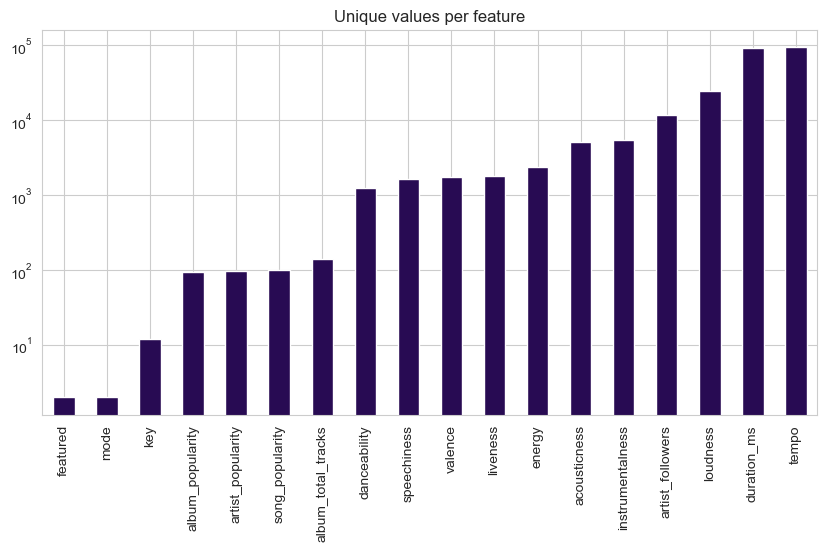

In [14]:
unique_values = df_lyrics.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(figsize=(10,5), title="Unique values per feature", logy=True)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Missing values investigation

Apart from NaN values, there are some empty string values in **lyrics** and **artist genre** columns. There are **696** records, where there is a lyrics, but there is not a specified genre. The rest of the existing lyrics (**31732**) will be used to train the classification model.


In [35]:
no_lyrics = (df_lyrics["lyrics"] == "") | (df_lyrics["lyrics"].isna())
no_genres = (df_lyrics["artist_genres"] == "") | (df_lyrics["artist_genres"].isna())

print("Empty lyrics:", len(df_lyrics[no_lyrics]))
print("Empty artist genre:", len(df_lyrics[no_genres]))
print("Lyrics, but no genre:", len(df_lyrics[no_genres & ~no_lyrics]))
print("Distinct Lyrics:", len(df_lyrics[~no_lyrics & ~no_genres]["lyrics"].unique()))

df_lyrics.loc[no_genres, "artist_genres"] = np.NaN
df_lyrics.loc[no_lyrics, "lyrics"] = np.NaN

Empty lyrics: 258745
Empty artist genre: 58560
Lyrics, but no genre: 696
Distinct Lyrics: 31732


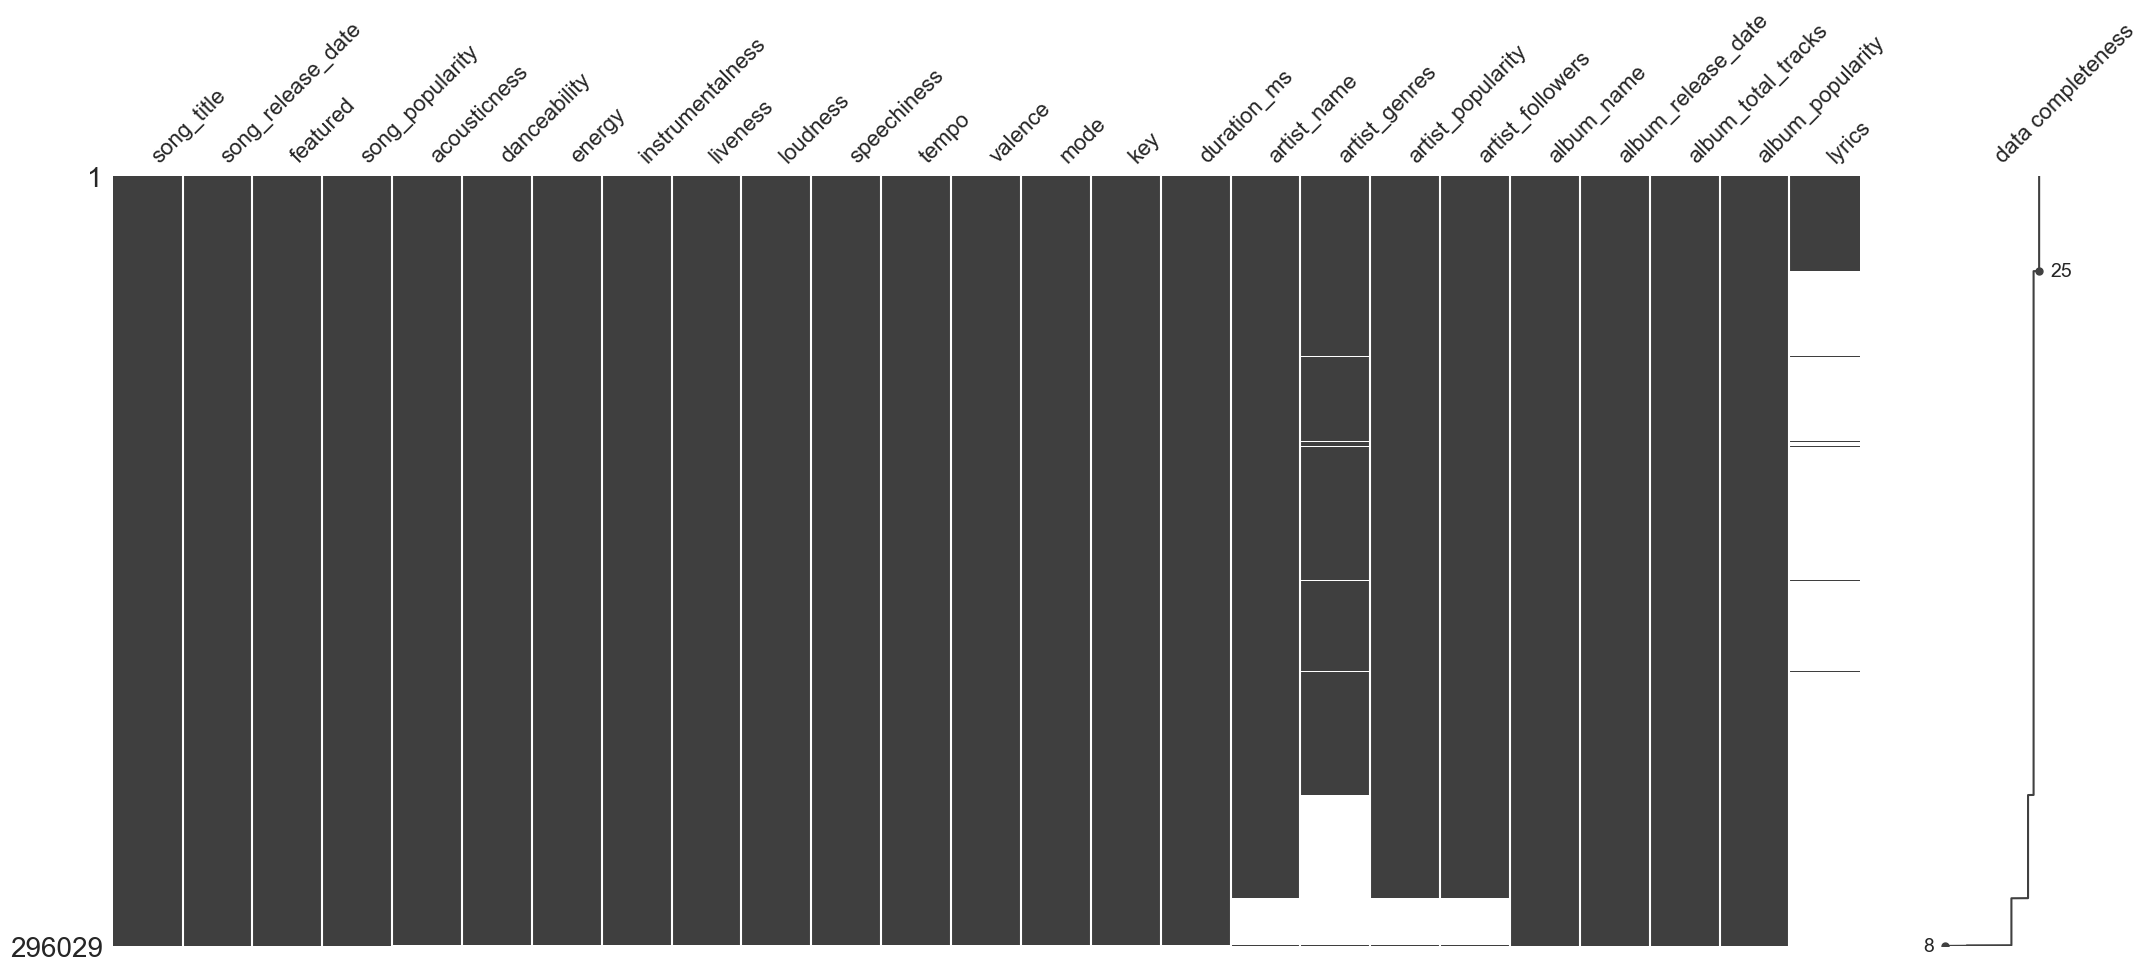

In [36]:
msno.matrix(df_lyrics, labels=True, sort="descending")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Two main objectives: Analysis and the Model

As these two have a little different requirements, I need to work on different parts of the data, first I will definitely drop the records where there is a **lack of the artist info**, especially the genre. After that I need to do a little bit of cleaning in terms of the:<br>

-**release_date**<br>
-**genres**

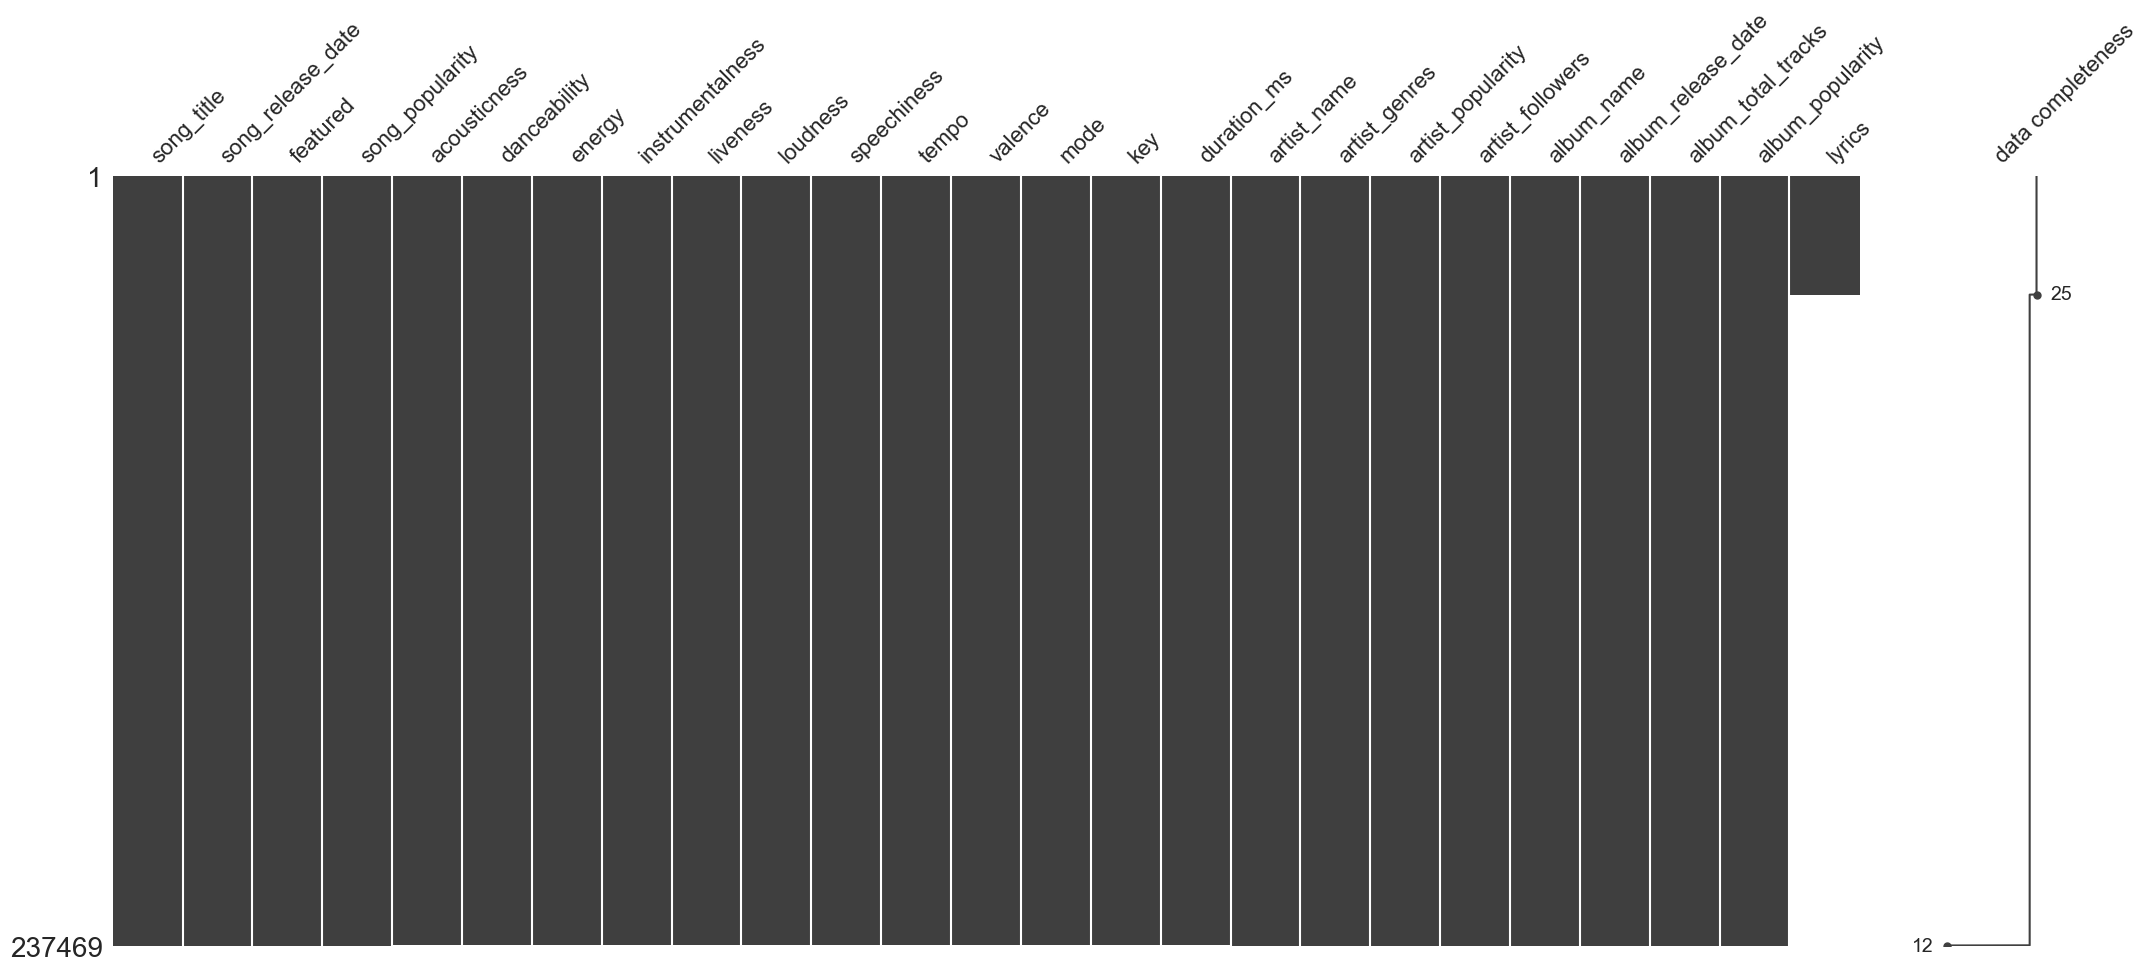

In [37]:
df_lyrics = df_lyrics.dropna(subset=["artist_genres"])
msno.matrix(df_lyrics, labels=True, sort="descending")
plt.show()

In [41]:
print("Song Release Date != Album Release Date:", len(df_lyrics[df_lyrics["song_release_date"] != df_lyrics["album_release_date"]]))
del df_lyrics["album_release_date"]

Song Release Date != Album Release Date: 0


In [65]:
dictionary = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

day_of_week = lambda date, dictionary: dictionary[datetime.strptime(date, "%Y-%m-%d").weekday()]

exact_date_precision = df_lyrics["song_release_date"].str.len() == 10

df_lyrics.loc[exact_date_precision, "day_of_week"] = df_lyrics.loc[exact_date_precision, "song_release_date"].apply(lambda x: day_of_week(x, dictionary))
df_lyrics["release_year"] = df_lyrics["song_release_date"].str[:4]

In [67]:
df_lyrics.head(3)

,song_title,song_release_date,featured,song_popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,artist_name,artist_genres,artist_popularity,artist_followers,album_name,album_total_tracks,album_popularity,lyrics,day_of_week,release_year
1,It's All Over Now - Mono Version,1964-10-17,0,47,0.0235,0.603,0.689,0.000003,0.3300,-10.729,...,The Rolling Stones,"album rock,british invasion,classic rock,rock",79.0,14083807.0,12 X 5,12,45,"Well, baby used to stay out all night long Sh...",Saturday,1964
3,It's Over,1962,0,44,0.7400,0.462,0.319,0.000758,0.0803,-12.448,...,Roy Orbison,"adult standards,classic rock,folk rock,mellow ...",68.0,2024651.0,"Oh, Pretty Woman",12,71,Your baby doesn't love you anymore Golden da...,NaN,1962
4,Ramona,2015-05-07,0,18,0.4800,0.679,0.422,0.000031,0.1540,-10.860,...,The Bachelors,british invasion,37.0,39741.0,The Collection,25,30,NaN,Thursday,2015


In [109]:
genre_map = {
    'pop': 'pop',
    'rock': 'rock',
    'jazz': 'jazz',
    'rap': 'rap',
    'classical': 'classical',
    'electronic': 'electronic',
    'british invasion': 'rock',
    'blues': 'blues',
    'soul': 'blues',
    'metal': 'metal',
    'indie': 'indie',
    'hip hop': 'hip hop',
    'folk': 'folk',
    'drill': 'drill',
    'disco': 'disco',
    'house': 'house',
    'techno': 'techno',
    'punk': 'rock',
    'house': 'electronic',
    'r&b': 'r&b',
    'christmas': 'christmas',
    'hardcore': 'techno',
    'funk': 'funk',
    'country': 'country',
    'latin': 'latin'
}

def map_genres(genres):
    mapped_genres = set()
    for genre in genres.split(', '):
        for key in genre_map:
            if key in genre:
                mapped_genres.add(genre_map[key])
    return ', '.join(mapped_genres)

all_genres = df_lyrics["artist_genres"]
gg = all_genres.apply(map_genres)
all_genres[(gg == "")]

6                             nashville sound
19                            nashville sound
28        chill lounge,deep chill,world chill
36                              chanson,ye ye
39        sad lo-fi,slowed and reverb,sped up
                         ...                 
295793     poezja spiewana,polish alternative
295794     poezja spiewana,polish alternative
295795     poezja spiewana,polish alternative
295796     poezja spiewana,polish alternative
295975                                doo-wop
Name: artist_genres, Length: 31541, dtype: object

In [85]:
all_genres

1             album rock,british invasion,classic rock,rock
3         adult standards,classic rock,folk rock,mellow ...
4                                          british invasion
5                               british invasion,merseybeat
6                                           nashville sound
                                ...                        
296024    british invasion,classic rock,merseybeat,psych...
296025    british invasion,classic rock,merseybeat,psych...
296026    british invasion,classic rock,merseybeat,psych...
296027    british invasion,classic rock,merseybeat,psych...
296028    british invasion,classic rock,merseybeat,psych...
Name: artist_genres, Length: 237469, dtype: object

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# The amount of each genre in dataset



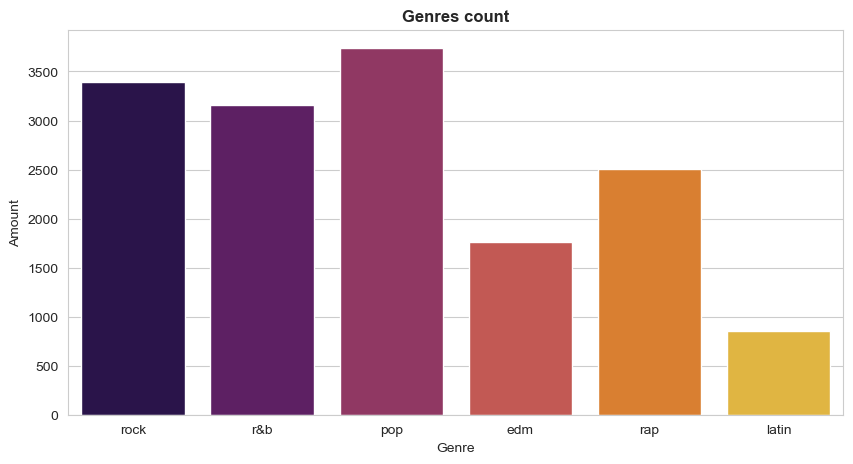

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="playlist_genre", hue="playlist_genre")
plt.title("Genres count", weight="bold")
plt.xlabel("Genre")
plt.ylabel("Amount")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Now let's see how this looks like across years

Dataset clearly contains mostly fresh songs, with a lack in 2020 year, probably due to the early month of dataset creation.



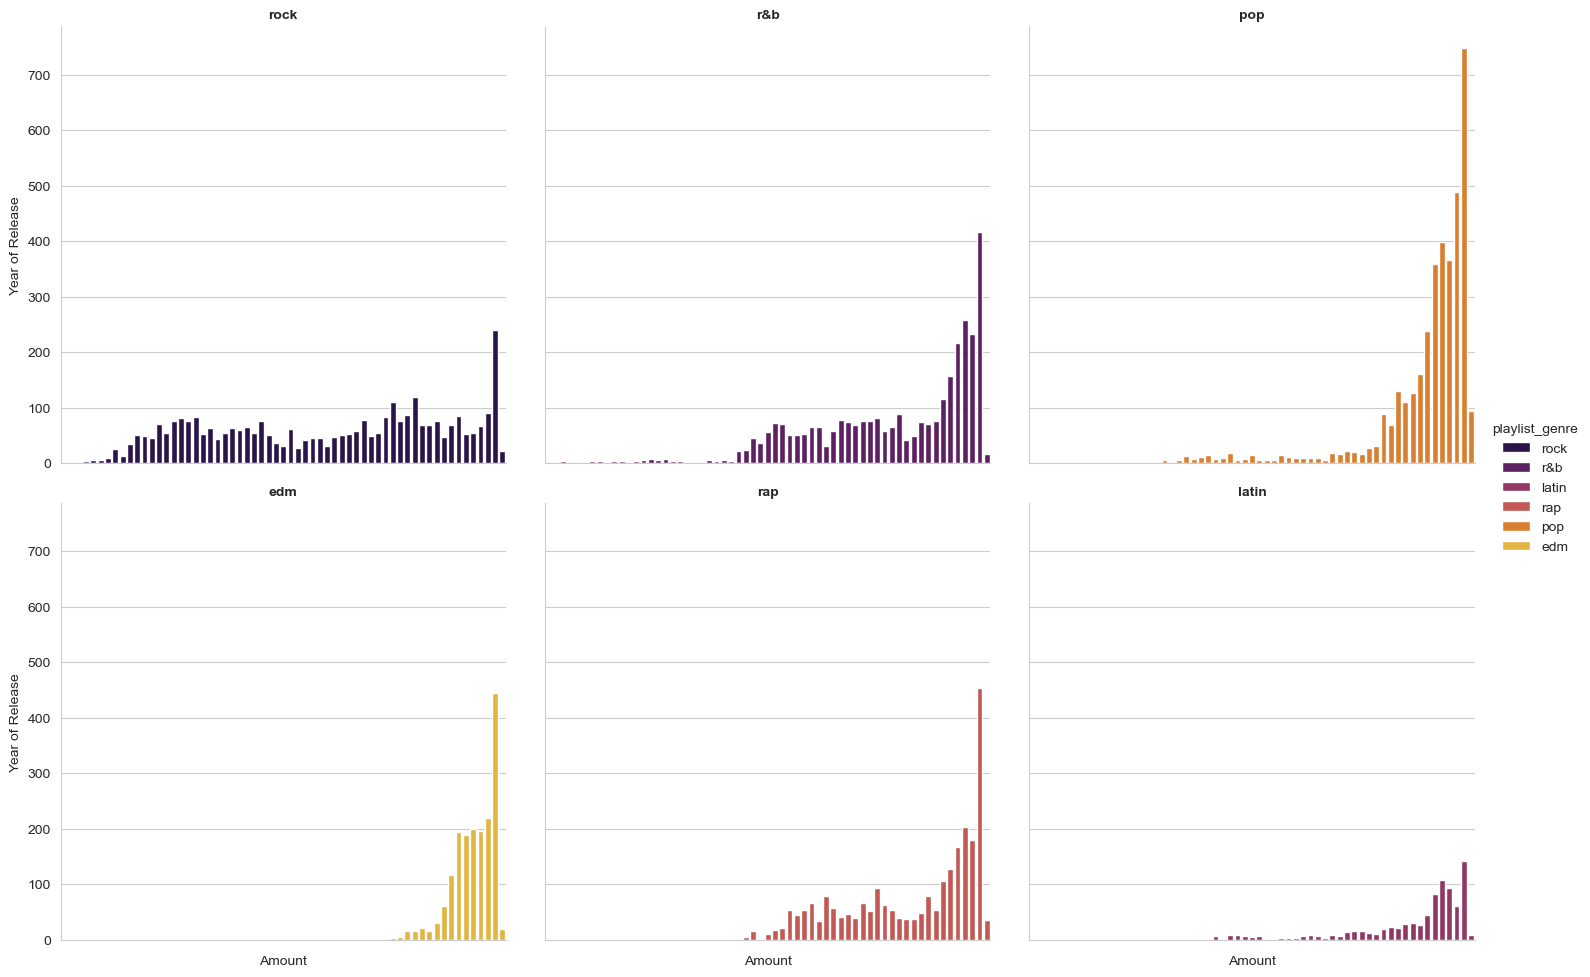

In [17]:
p = sns.catplot(data=df,
                x="release_year",
                col="playlist_genre",
                kind="count",
                col_wrap=3,
                hue="playlist_genre",
               )
p.set_titles("{col_name}", weight="bold")
p.set_axis_labels("Amount", "Year of Release")
p.set(xticklabels=[]) 

plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's have a grasp of how data looks like

Now we can see, that we have one **binary** (mode), and one **ordinary** (key) feature.<br> The rest is numerical, and vary in their values.



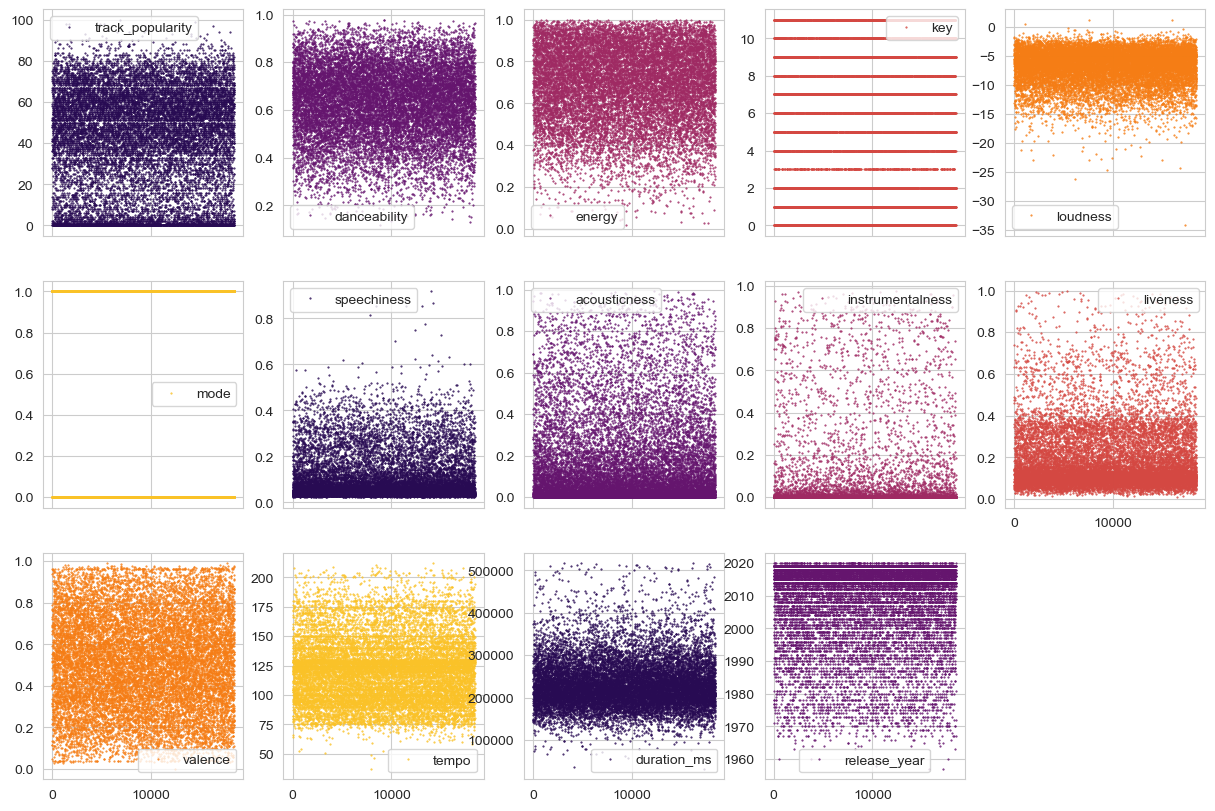

In [18]:
df.plot(lw=0, marker=".", subplots=True, layout=(-1,5), figsize=(15,10), markersize=1)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Most frequent artists in dataset

Wooah! There is over **120 Queen's songs** in the dataset!<br>
That's almost 2x more than the second position - **Don Omar**.
<br><br>
To be honest, I find it a little bit **suspicious**.
<br>
Let's look at the duplicates then!



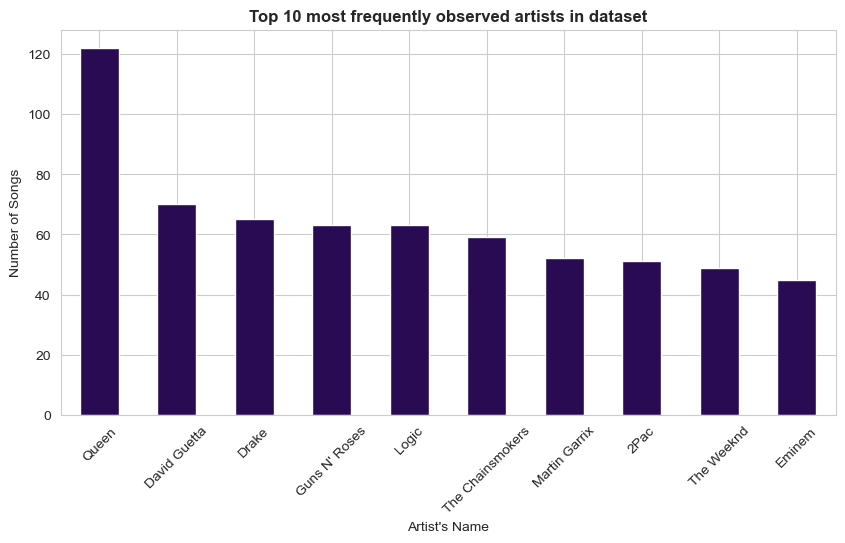

In [19]:
most_frequent_artists = df["track_artist"].value_counts().sort_values(ascending=False).head(10)
most_frequent_artists.plot(kind="bar", figsize=(10, 5))
plt.title("Top 10 most frequently observed artists in dataset", weight="bold")
plt.xlabel("Artist's Name")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's see the duplicates

Yeah, as I supposed - Almost **2000 of duplicated entries**, mainly for the artists from the previous graph.
<br>
Let's get rid of them and continue the analysis.



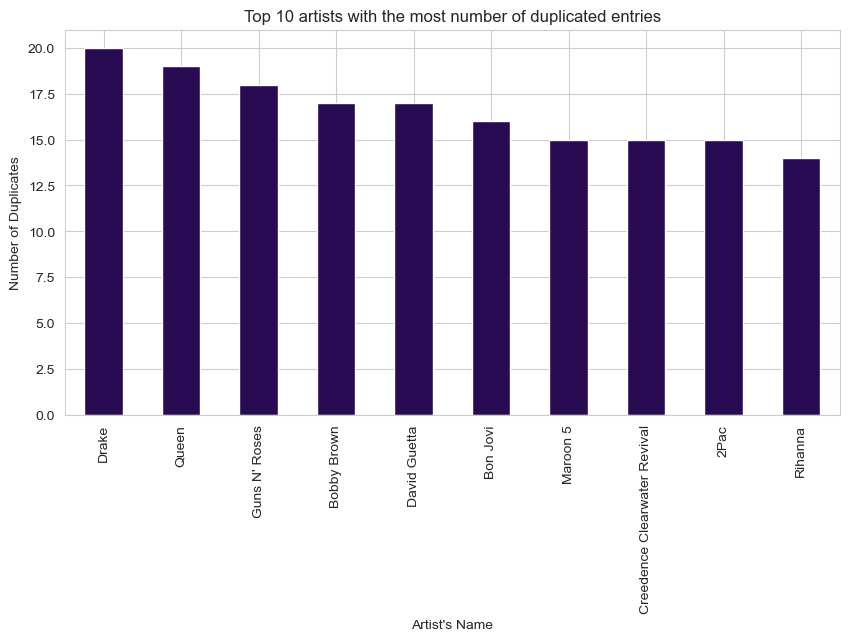

In [20]:
no_duplicates = df.drop_duplicates(subset=["track_name", "track_artist"])

duplicates = df[~df.isin(no_duplicates)].dropna()

duplicates["track_artist"].value_counts().sort_values(ascending=False).head(10).plot(kind="bar", figsize=(10,5))
plt.title("Top 10 artists with the most number of duplicated entries")
plt.xlabel("Artist's Name")
plt.ylabel("Number of Duplicates")
plt.show()

In [21]:
duplicates.shape[0]

1679

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's look at the feature distribution

Ok, so **first insights from the distrubutions:**

- **Strong right skewness** in terms of **speechiness, acousticness, instrumentalness** makes these features inbalanced in this dataset, presenting the songs mostly as the opposites of these metrics.

- Similiar situation is found in **liveness**, however the effect is not as strong as in the previously mentioned features.

- As I already mentioned before, where I only looked at the **Release year** distribution, there is a huge inbalance between new songs and the songs released in the far past. However this should not make a bigger problem, as I am not intending to predict, taking the year into account.


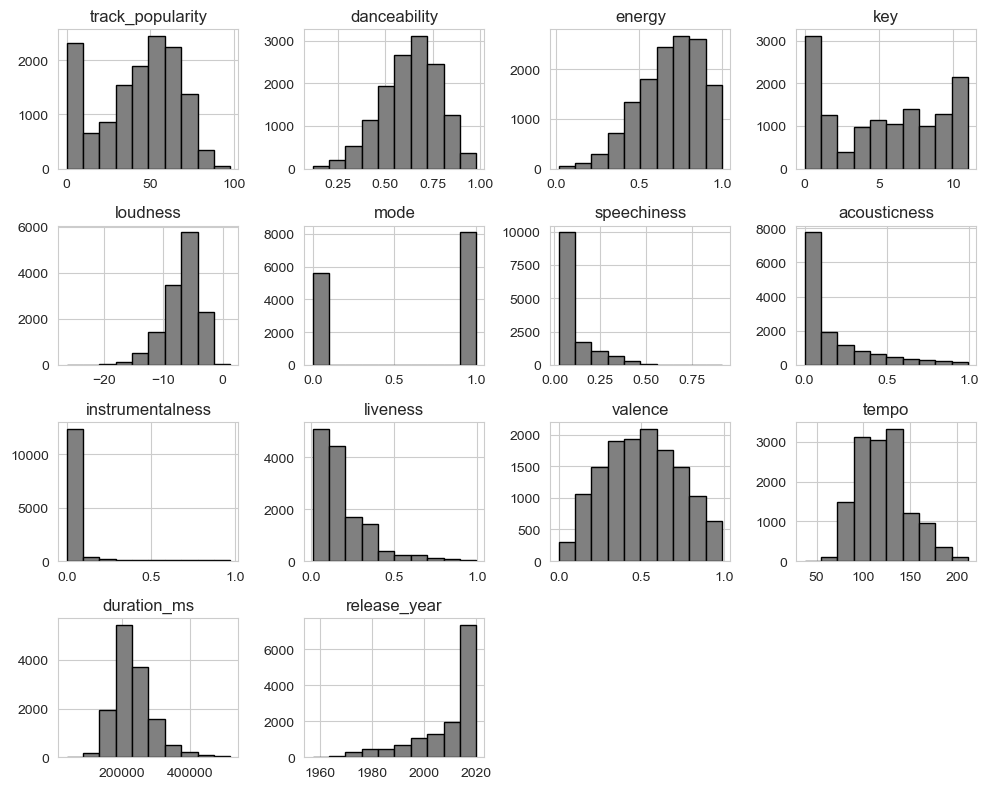

In [22]:
no_duplicates.hist(figsize=(10,8), layout=(-1,4), edgecolor="black", color="gray", bins=10)
plt.tight_layout()
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Ok, let's see the relations between every feature

The **hexbin** will help to locate where the most of the data is located in the scatterplots.


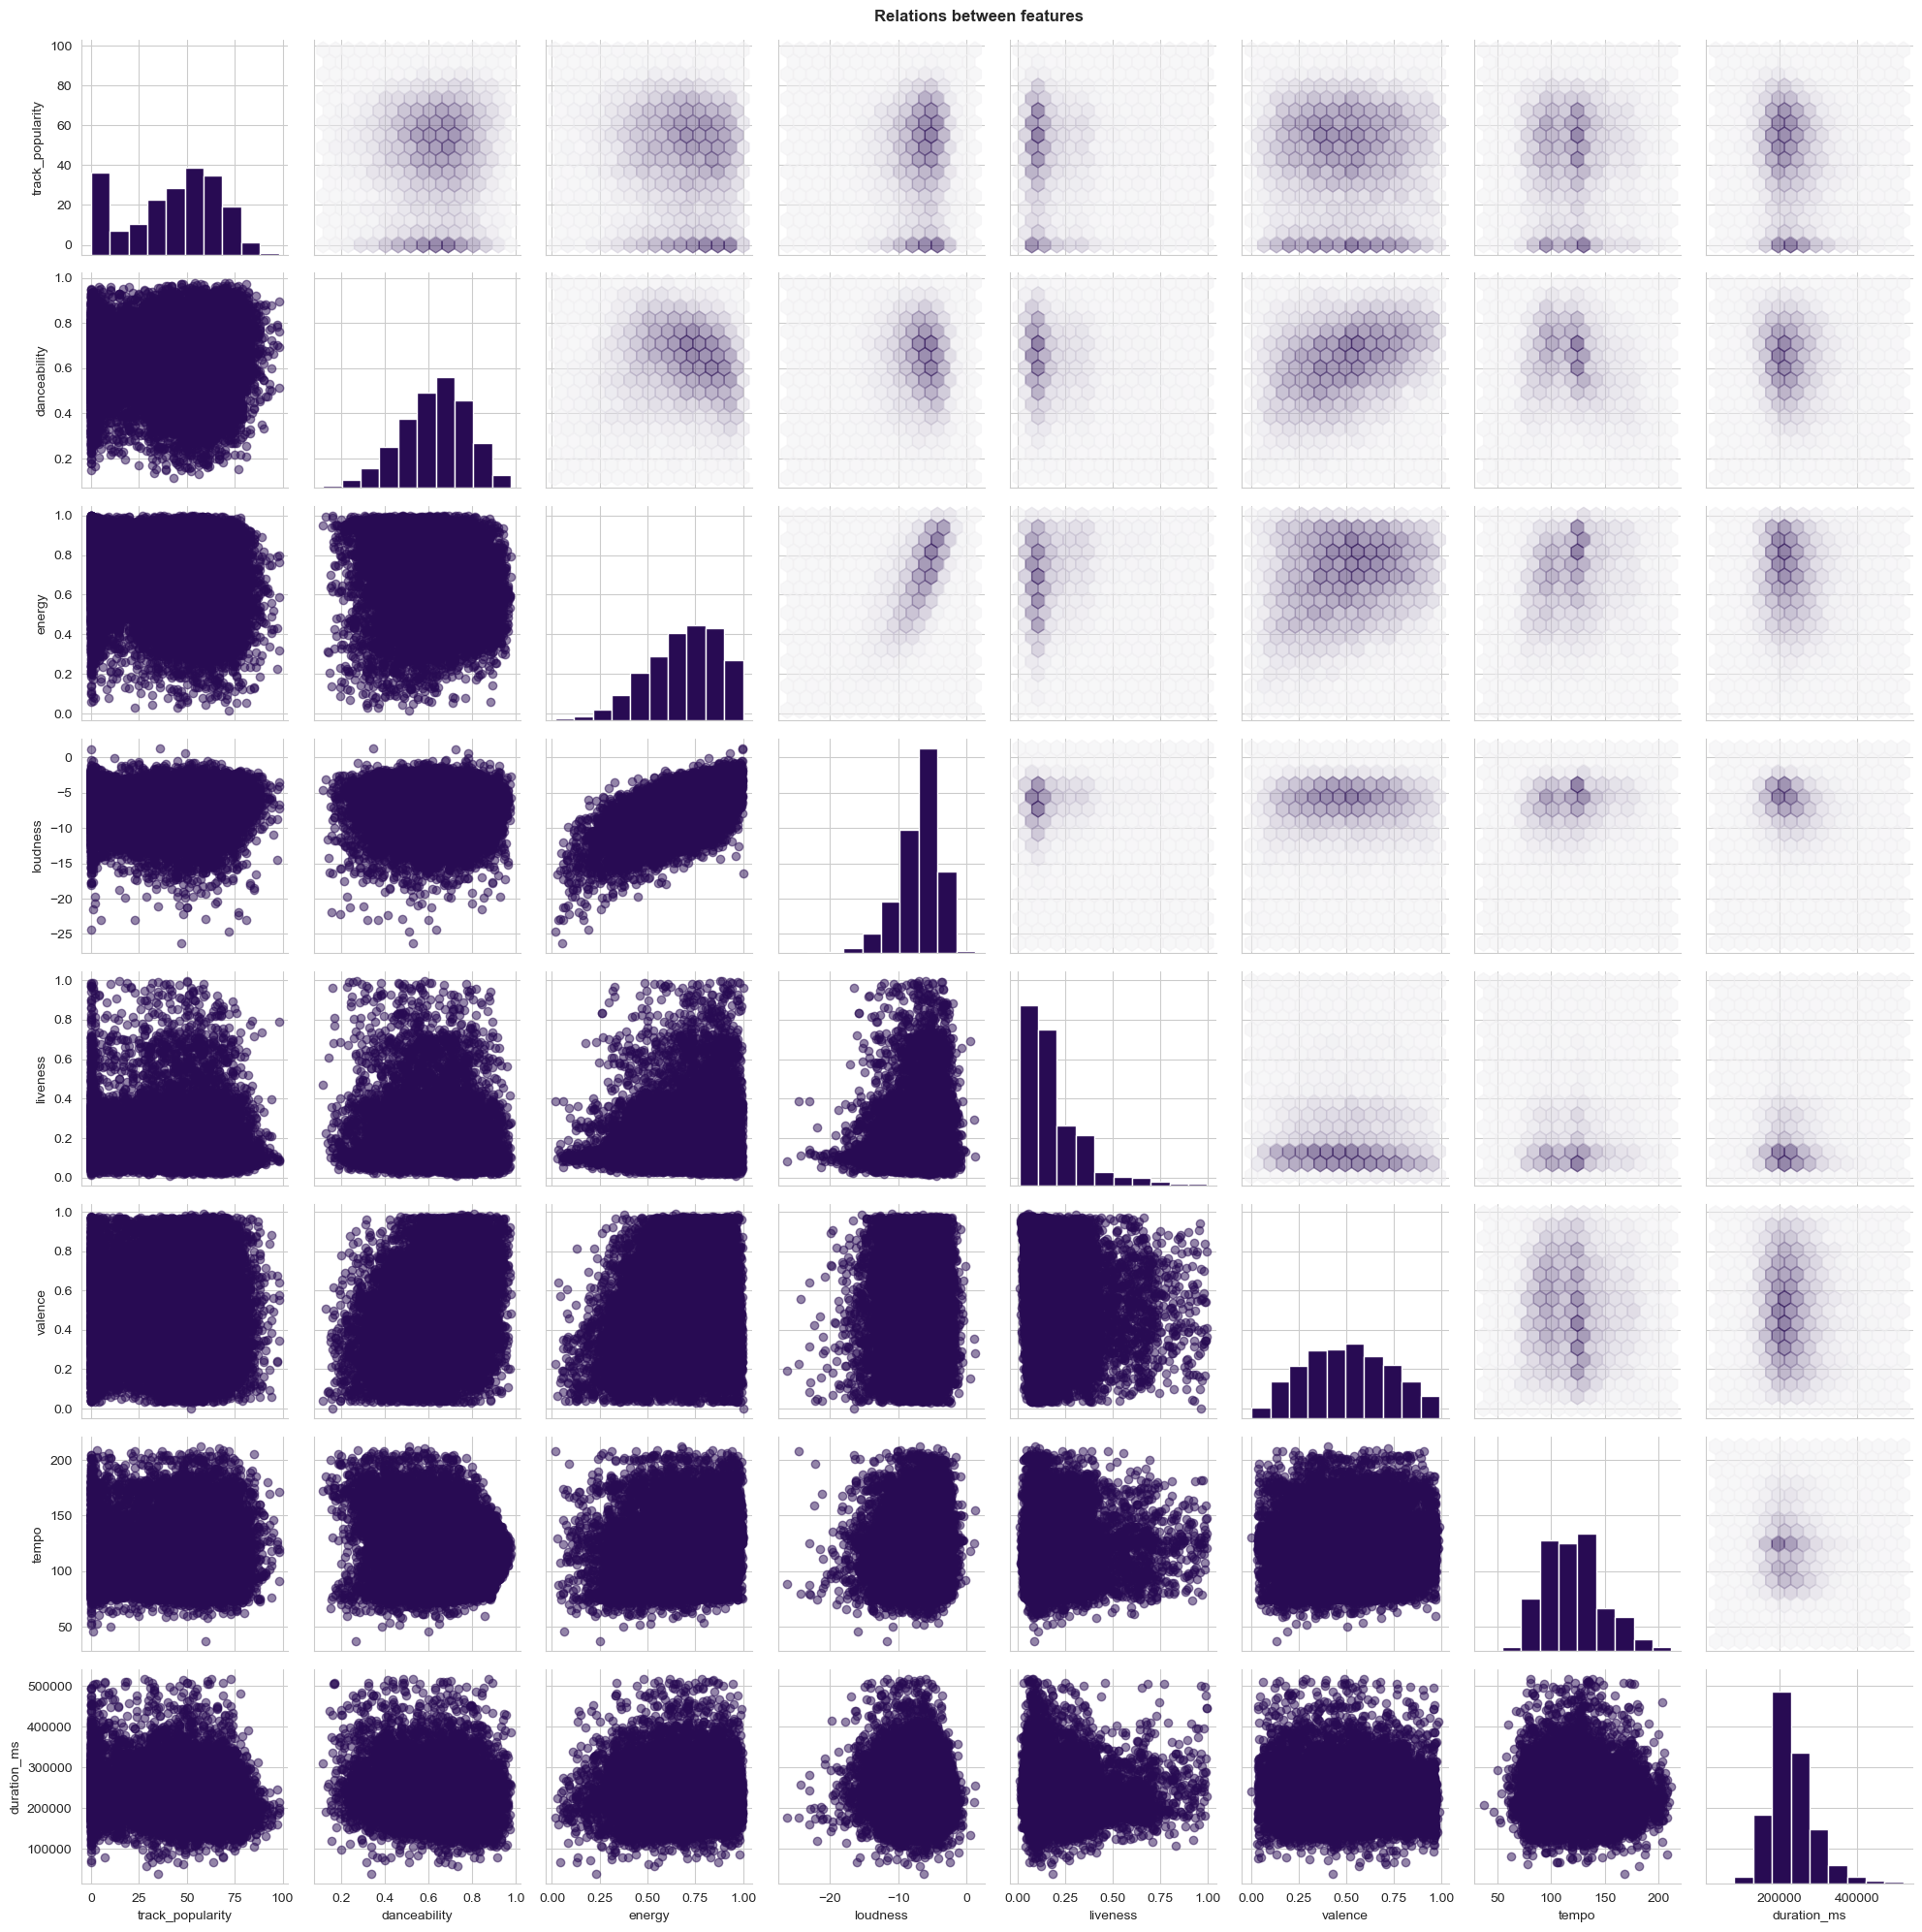

In [23]:
numerical_features = no_duplicates.select_dtypes(include="number").nunique() > 12
data_continous = no_duplicates[numerical_features[numerical_features].index]

def hex_pairplot(data, vars=None):

    def hexbin(x, y, color, max_series=None, min_series=None, **kwargs):
        cmap = sns.light_palette(color, as_cmap=True)
        ax = plt.gca()
        xmin, xmax = min_series[x.name], max_series[x.name]
        ymin, ymax = min_series[y.name], max_series[y.name]
        plt.hexbin(x, y, gridsize=15, cmap=cmap, extent=[xmin, xmax, ymin, ymax], **kwargs)
    if vars:
        g = sns.PairGrid(data[vars])
    else:
        g = sns.PairGrid(data)
    g.map_diag(plt.hist)
    g.map_lower(plt.scatter, alpha=0.5)
    g.map_upper(hexbin, min_series=data.min(), max_series=data.max(), alpha=0.5)

    return g

# excluding the strongly skewed features
g = hex_pairplot(data_continous, vars=["track_popularity", "danceability", "energy", "loudness", "liveness", "valence", "tempo", "duration_ms"])
g.fig.suptitle("Relations between features", y=1, weight="bold")
plt.show()

In [24]:
corr = no_duplicates.select_dtypes(include="number").corr()

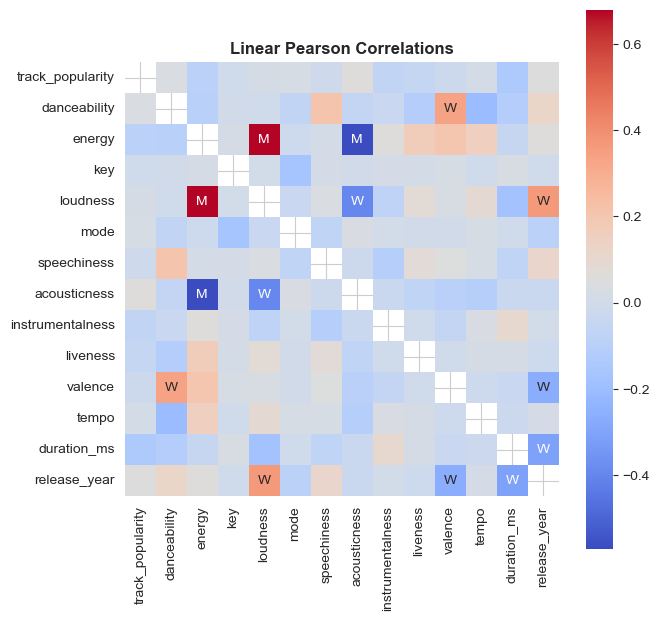

In [25]:
labels = np.where(np.abs(corr)>0.75, "S",
                  np.where(np.abs(corr)>0.5, "M",
                           np.where(np.abs(corr)>0.25, "W", "")))

plt.figure(figsize=(7,7))
sns.heatmap(corr, mask=np.eye(len(corr)),
            square=True, annot=labels, fmt='',
            cmap="coolwarm")
plt.title("Linear Pearson Correlations", weight="bold")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# What's next?

Before I dive in to the **analysis related to words used in lyrics**, I would like to see how different **metrics** differ across different **genres**.<br>


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
vectorizer = TfidfVectorizer()

In [28]:
sample_data = no_duplicates["lyrics"]
sample_data[:5]

1    The trees, are singing in the wind The sky blu...
2    NA Yeah, Spyderman and Freeze in full effect U...
3    I really can't stay Baby it's cold outside I'v...
4    Get up out of my business You don't keep me fr...
5    Hold your breath, don't look down, keep trying...
Name: lyrics, dtype: object

In [41]:
words = vectorizer.fit_transform(sample_data)

In [115]:
words_df = pd.DataFrame.sparse.from_spmatrix(words, columns=vectorizer.get_feature_names_out())
no_duplicates = no_duplicates.reset_index(drop=True)

In [120]:
no_duplicates.columns

Index(['track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_name', 'track_album_release_date', 'playlist_name',
       'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'language',
       'release_year'],
      dtype='object')

In [121]:
no_duplicates = no_duplicates.rename(columns={"energy": "energy_level", "danceability": "danceability_level",
                                              "key": "key_level", "loudness": "loudness_level",
                                              "valence": "valence_level", "tempo": "tempo_level"})
data = pd.concat([no_duplicates.drop(["lyrics", "language"], axis=1), words_df], axis=1)

In [122]:
data.head()

,track_name,track_artist,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability_level,energy_level,...,힘껏,힘들다,힘들어,힘들어져,힘이,ﬁght,ﬁnd,ﬁndin,ﬁne,ﬁre
0,I Feel Alive,Steady Rollin,28,Love & Loss,2017-11-21,Hard Rock Workout,rock,hard rock,0.303,0.880,...,0,0,0,0,0,0,0,0,0,0
1,Poison,Bell Biv DeVoe,0,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",r&b,new jack swing,0.845,0.652,...,0,0,0,0,0,0,0,0,0,0
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,41,CeeLo's Magic Moment,2012-10-29,Christmas Soul,r&b,neo soul,0.425,0.378,...,0,0,0,0,0,0,0,0,0,0
3,Dumb Litty,KARD,65,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,pop,dance pop,0.760,0.887,...,0,0,0,0,0,0,0,0,0,0
4,Soldier,James TW,70,Chapters,2019-04-26,urban contemporary,r&b,urban contemporary,0.496,0.639,...,0,0,0,0,0,0,0,0,0,0


In [123]:
curse_words = ["fuck", "shit", "bitch", "ass", "asshole", "slut", "whore", "motherfucker", "piss", "cunt", "damn", "dick", "pussy", "bullshit", "bastard"]
data["curse_words"] = 0
for c_word in curse_words:
    try:
        data["curse_words"] += data[c_word]
    except:
        pass

<Axes: xlabel='playlist_genre'>

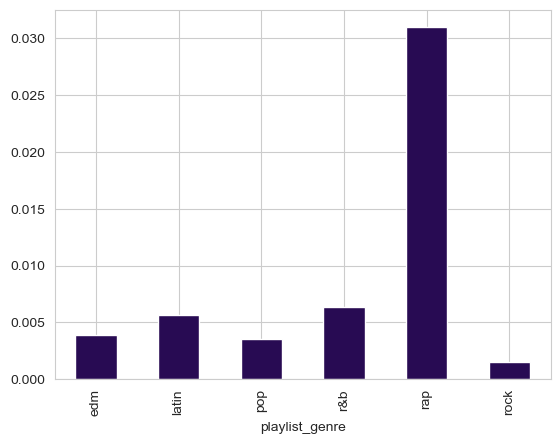

In [142]:
data.groupby(["playlist_genre"])["curse_words"].mean().plot(kind="bar")

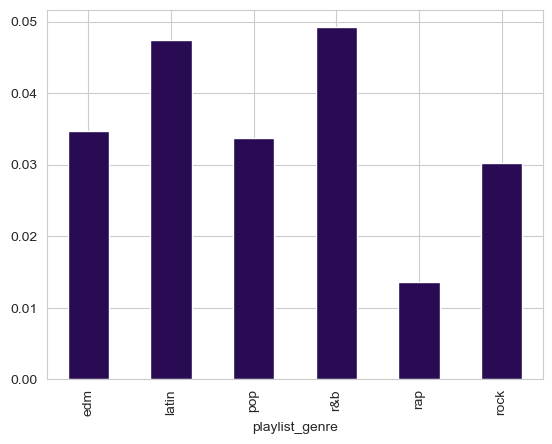

In [148]:
data.groupby("playlist_genre")["love"].mean().plot(kind="bar")
plt.show()